## 准备好建立网络所需

In [1]:
import numpy as np

In [2]:
def softmax_function(x):
    return np.exp(x) / np.sum(np.exp(x))

def sigmoid_function(x):
    return 1/ (1 + np.exp(-x))

def dfunc(f, x):
    h = 1e-4 
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'])
    while not it.finished:     
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        it.iternext()   
    return grad

def cross_entropy_err(y_hat, y):
    delta = 1e-8
    return -np.sum(y*np.log(y_hat + delta))

In [4]:
class ANN:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
 
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid_function(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax_function(a2)
        return y
        
    def loss(self, x, y):
        y_hat = self.predict(x)
        return cross_entropy_err(y_hat, y)
        
    def numerical_gradient(self, x, y):
        loss_W = lambda W: self.loss(x, y)
        grads = {}
        grads['W1'] = dfunc(loss_W, self.params['W1'])
        grads['b1'] = dfunc(loss_W, self.params['b1'])
        grads['W2'] = dfunc(loss_W, self.params['W2'])
        grads['b2'] = dfunc(loss_W, self.params['b2'])
        return grads

## 建立一两层神经网络

In [5]:
net = ANN(input_size=4, hidden_size=5, output_size=3)

In [6]:
net.params['W1']

array([[-0.03210503,  0.00685672,  0.00013808, -0.00989123,  0.00310228],
       [ 0.01247699,  0.0101178 , -0.00086327,  0.01177054,  0.00709769],
       [-0.00768559,  0.01629381,  0.00412   , -0.00550643, -0.01051893],
       [-0.00265321, -0.01284534, -0.01305434,  0.00550098,  0.00363593]])

In [7]:
net.params['b1']

array([0., 0., 0., 0., 0.])

In [88]:
net.params['W1'].shape
net.params['b1'].shape

(5,)

In [8]:
net.params['W2']

array([[ 0.00042467,  0.00300935, -0.01456152],
       [ 0.01079981,  0.00675796,  0.0047648 ],
       [ 0.02759437,  0.00027935, -0.00979699],
       [ 0.02805719, -0.00420709,  0.00908706],
       [-0.00308693, -0.00796533,  0.00830164]])

In [9]:
net.params['b2']

array([0., 0., 0.])

In [90]:
net.params['W2'].shape
net.params['b2'].shape

(3,)

## 准备好建立网络所需数据

In [10]:
from sklearn.datasets import load_iris
iris = load_iris()
x= iris.data

In [12]:
#x

In [13]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [14]:
y = np.zeros((len(iris.target), 3))
for idx, val in enumerate(iris.target):
    y[idx, val] = 1

In [16]:
#y

In [17]:
y_hat = net.predict(x)

In [19]:
y_hat.shape

(150, 3)

In [21]:
y - y_hat

array([[ 0.99772905, -0.00219713, -0.00219833],
       [ 0.99772914, -0.00219713, -0.00219827],
       [ 0.99772908, -0.00219713, -0.00219823],
       [ 0.99772907, -0.00219715, -0.0021982 ],
       [ 0.99772902, -0.00219713, -0.00219831],
       [ 0.99772901, -0.00219714, -0.00219843],
       [ 0.99772903, -0.00219713, -0.00219822],
       [ 0.99772905, -0.00219714, -0.0021983 ],
       [ 0.9977291 , -0.00219714, -0.00219815],
       [ 0.99772909, -0.00219715, -0.00219826],
       [ 0.99772904, -0.00219714, -0.00219841],
       [ 0.99772902, -0.00219716, -0.00219826],
       [ 0.99772911, -0.00219714, -0.00219824],
       [ 0.99772907, -0.00219712, -0.00219812],
       [ 0.99772905, -0.0021971 , -0.00219851],
       [ 0.99772896, -0.00219711, -0.00219851],
       [ 0.99772905, -0.0021971 , -0.00219843],
       [ 0.99772907, -0.00219712, -0.00219834],
       [ 0.99772905, -0.00219714, -0.00219849],
       [ 0.997729  , -0.00219713, -0.00219835],
       [ 0.99772909, -0.00219716, -0.002

## 训练类神经网络

In [34]:
import time
a = time.clock()
epochs = 3000
lr     = 0.01

train_loss = []
for i in range(epochs):         
    grad = net.numerical_gradient(x,y)
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] = net.params[key] - lr * grad[key]
    loss = net.loss(x, y)
    train_loss.append(loss)
time.clock() -a

17.157719999999998

In [23]:
#train_loss

## 训练损失图

Populating the interactive namespace from numpy and matplotlib


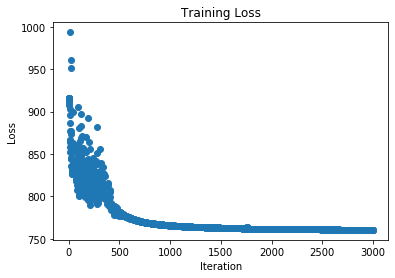

In [25]:
%pylab inline
import matplotlib.pyplot as plt
plt.scatter(range(0,3000),train_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 验证模型准确度

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix
#net.predict(x)
predicted = np.argmax(net.predict(x), axis=1)

In [27]:
#predicted

In [28]:
# accuracy
sum(predicted == iris.target) / len(iris.target)

0.98

In [110]:
# accuracy
accuracy_score(iris.target, predicted)

0.98

In [111]:
# confusion matrix
confusion_matrix(iris.target, predicted)

array([[50,  0,  0],
       [ 0, 47,  3],
       [ 0,  0, 50]])

## 调整交叉熵 

In [112]:
def cross_entropy_err(y_hat, y):
    y      = y.reshape(1, y.size)
    y_hat  = y_hat.reshape(1, y_hat.size)
    batch_size = y_hat.shape[0]
    return -np.sum(y * np.log(y_hat)) / batch_size

## 批次学习

In [113]:
net = ANN(input_size=4, hidden_size=5, output_size=3)

epochs     = 3000
lr         = 0.01
batch_size = 30

train_loss = []
for i in range(epochs): 
    idx = np.random.choice(iris.data.shape[0], batch_size)
    x_batch   = iris.data[idx]
    y_batch   = y[idx]
    grad = net.numerical_gradient(x_batch,y_batch)
    for key in ('W1', 'b1', 'W2', 'b2'):
        net.params[key] = net.params[key] - lr * grad[key]
    loss = net.loss(x_batch, y_batch)
    train_loss.append(loss)

Text(0.5,1,'Training Loss')

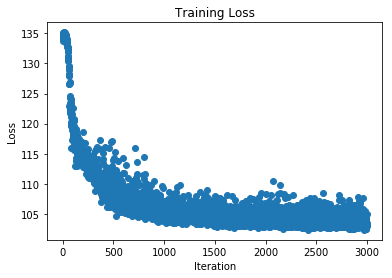

In [114]:
plt.scatter(range(0,3000),train_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')

In [115]:
from sklearn.metrics import accuracy_score, confusion_matrix
predicted = np.argmax(net.predict(x), axis=1)

# accuracy
sum(predicted == iris.target) / len(iris.target)

0.9733333333333334

In [116]:
# accuracy
accuracy_score(iris.target, predicted)

0.9733333333333334

In [117]:
# confusion matrix
confusion_matrix(iris.target, predicted)

array([[50,  0,  0],
       [ 0, 46,  4],
       [ 0,  0, 50]])

In [30]:
net.params['W1']

array([[ 2.50010016, -0.84753194,  4.09555837, -0.58543634, -4.09126851],
       [ 4.03176042, -2.64921168,  2.95216725,  0.54598561, -4.77760827],
       [-4.76145605,  4.40283185, -5.92304228, -2.63160855,  6.24879742],
       [-5.30647729,  2.11465715, -6.13714208, -1.2751506 ,  8.80280972]])

In [31]:
net.params['b1']

array([ 2.99286952, -0.53316119,  3.4938831 ,  0.11668669, -7.42206836])

In [32]:
net.params['W2']

array([[ 3.01987975, -0.10665899, -5.44585136],
       [-6.25249935,  6.7647444 ,  3.54878241],
       [ 2.53388847,  0.04602202, -5.43880835],
       [ 0.64457859, -0.69113497, -1.65615543],
       [-1.1894297 , -4.90342002, -0.32933171]])

In [33]:
net.params['b2']

array([-0.34358427, -1.56037175,  1.90395445])